In [1]:
from tqdm import tqdm
import pandas as pd
from datetime import timedelta
from matplotlib import pyplot as plt
import seaborn as sns
from heapq import nlargest

In [2]:
TRAIN_PATH = r'C:\Users\cs_mibra004\Classes\train.jsonl'
with open(TRAIN_PATH, 'r') as f:
    # Initialize the dictionary to store the counts
    print(f"We have {len(f.readlines()):,} lines in the training data")

sample_size = 150000

chunks = pd.read_json(TRAIN_PATH, lines=True, chunksize = sample_size)


We have 12,899,779 lines in the training data


In [3]:
for c in chunks:
    sample_train_df = c
    break


sample_train_df.set_index('session', drop=True, inplace=True)
#pd.set_option('display.max_colwidth', -1)
print(sample_train_df.head())

example_session = sample_train_df.iloc[0].item()
print(f'This session was {len(example_session)} actions long \n')

                                                    events
session                                                   
0        [{'aid': 1517085, 'ts': 1659304800025, 'type':...
1        [{'aid': 424964, 'ts': 1659304800025, 'type': ...
2        [{'aid': 763743, 'ts': 1659304800038, 'type': ...
3        [{'aid': 1425967, 'ts': 1659304800095, 'type':...
4        [{'aid': 613619, 'ts': 1659304800119, 'type': ...
This session was 276 actions long 



In [4]:
# Time of session
time_elapsed = example_session[-1]["ts"] - example_session[0]["ts"]
# The timestamp is in milliseconds since 00:00:00 UTC on 1 January 1970
print(f'The first session elapsed: {str(timedelta(milliseconds=time_elapsed))} \n')

# Count the frequency of actions within the session
action_counts = {}
for action in example_session:
    action_counts[action['type']] = action_counts.get(action['type'], 0) + 1  
print(f'The first session contains the following frequency of actions: {action_counts}')

The first session elapsed: 27 days, 13:09:43.682000 

The first session contains the following frequency of actions: {'clicks': 255, 'carts': 17, 'orders': 4}


In [5]:
action_counts_list, article_id_counts_list, session_length_time_list, session_length_action_list = ([] for i in range(4))
overall_action_counts = {}
overall_article_id_counts = {}

for i, row in tqdm(sample_train_df.iterrows(), total=len(sample_train_df)):
    
    actions = row['events']
    
    # Get the frequency of actions and article_ids
    action_counts = {}
    article_id_counts = {}
    for action in actions:
        action_counts[action['type']] = action_counts.get(action['type'], 0) + 1
        action_counts
        article_id_counts[action['aid']] = article_id_counts.get(action['aid'], 0) + 1
        article_id_counts
        overall_action_counts[action['type']] = overall_action_counts.get(action['type'], 0) + 1
        overall_action_counts
        overall_article_id_counts[action['aid']] = overall_article_id_counts.get(action['aid'], 0) + 1
        overall_article_id_counts
        
    # Get the length of the session
    session_length_time = actions[-1]['ts'] - actions[0]['ts']
    
    # Add to list
    action_counts_list.append(action_counts)
    article_id_counts_list.append(article_id_counts)
    session_length_time_list.append(session_length_time)
    session_length_action_list.append(len(actions))

100%|██████████| 150000/150000 [00:09<00:00, 16658.51it/s]


min 2
max 495
134804


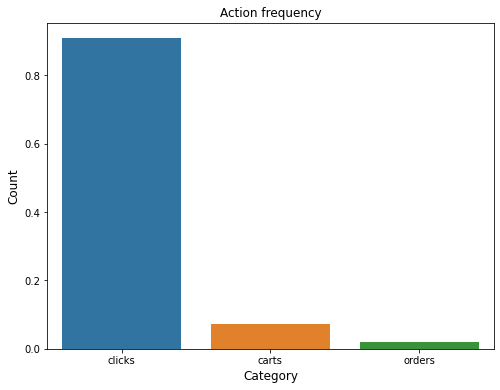

In [6]:
sample_train_df['action_counts'] = action_counts_list
sample_train_df['article_id_counts'] = article_id_counts_list
sample_train_df['session_length_unix'] = session_length_time_list
sample_train_df['session_length_hours'] = sample_train_df['session_length_unix']*2.77778e-7  # Convert to hours
sample_train_df['session_length_action'] = session_length_action_list
sample_train_df.head(2)
print("min",min(session_length_action_list))
print("max",max(session_length_action_list))
print(len(sample_train_df.loc[sample_train_df['session_length_action'] <=150]))

total_actions = sum(overall_action_counts.values())

plt.figure(figsize=(8,6))
sns.barplot(x=list(overall_action_counts.keys()), y=[i/total_actions for i in overall_action_counts.values()]);
plt.title(f'Action frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

c:\tools\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


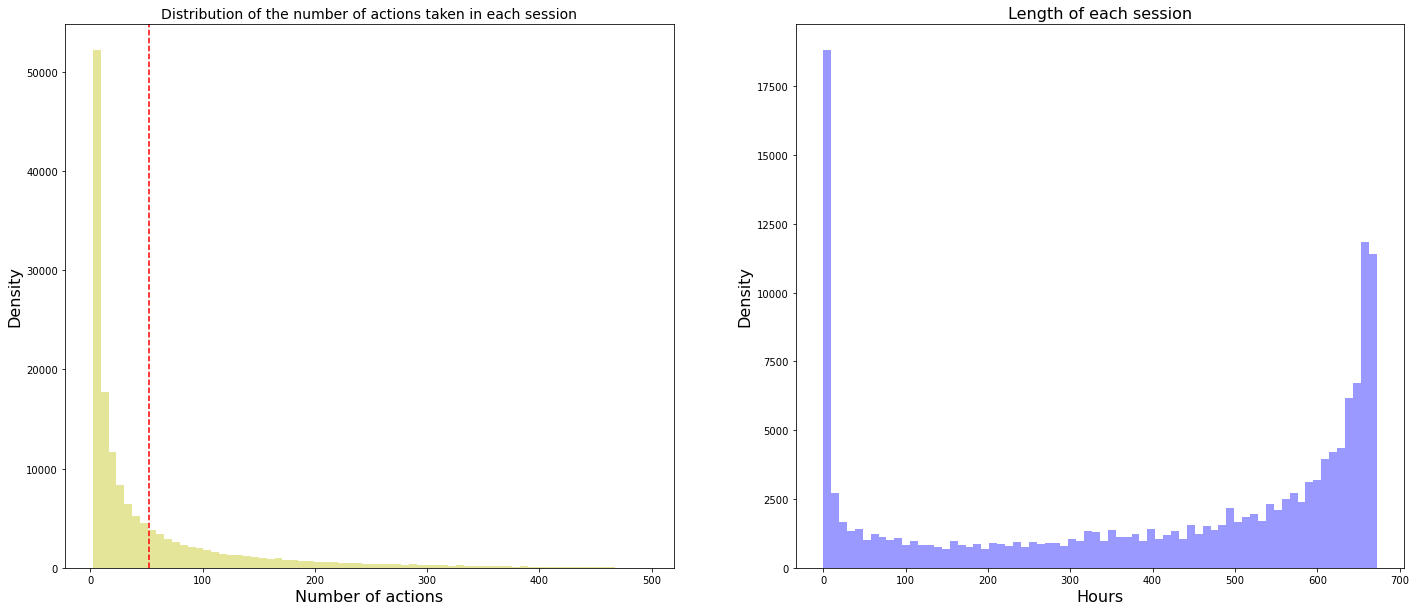

In [7]:
fig, ax = plt.subplots(1,2, figsize=(24, 10))

p = sns.distplot(sample_train_df['session_length_action'], color="y", bins= 70, ax=ax[0], kde=False)
p.set_xlabel("Number of actions", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Distribution of the number of actions taken in each session", fontsize = 14)
p.axvline(sample_train_df['session_length_action'].mean(), color='r', linestyle='--', label="Mean")

p = sns.distplot(sample_train_df['session_length_hours'], color="b", bins= 70, ax=ax[1], kde=False)
p.set_xlabel("Hours", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Length of each session", fontsize = 16)
plt.show()

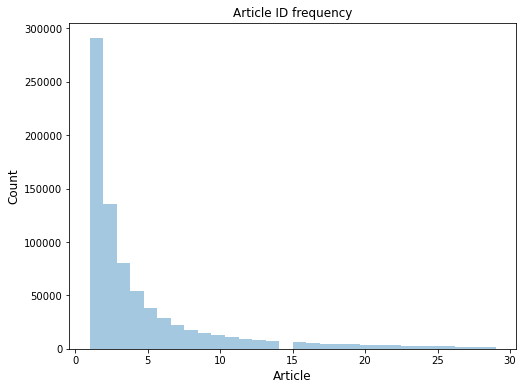

session
0    661.162663
1    669.460249
2    669.282652
3    501.352256
4    633.856392
Name: session_length_hours, dtype: float64
Frequency of most common articles: [3877, 4259, 4323, 4503, 5000] 

IDs for those common articles: [29735, 1603001, 832192, 1733943, 108125]


In [8]:
article_id_freq = list(overall_article_id_counts.values())
cut_off = [i for i in article_id_freq if i<30]

plt.figure(figsize=(8,6))
sns.distplot(cut_off, bins=30, kde=False)
plt.title(f'Article ID frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Article', fontsize=12)
plt.show()

print(sample_train_df['session_length_hours'].head())

print(f'Frequency of most common articles: {sorted(list(overall_article_id_counts.values()))[-5:]} \n')
res = nlargest(5, overall_article_id_counts, key = overall_article_id_counts.get)
print(f'IDs for those common articles: {res}')

In [9]:
TEST_PATH = r'C:\Users\cs_mibra004\Classes\test.jsonl'

with open(TEST_PATH, 'r') as f:
    print(f"We have {len(f.readlines()):,} lines in the test data")

sample_size = 150

chunks = pd.read_json(TEST_PATH, lines=True, chunksize = sample_size)

for c in chunks:
    sample_test_df = c
    break

print(sample_test_df.head())

We have 1,671,803 lines in the test data
    session                                             events
0  12899779  [{'aid': 59625, 'ts': 1661724000278, 'type': '...
1  12899780  [{'aid': 1142000, 'ts': 1661724000378, 'type':...
2  12899781  [{'aid': 141736, 'ts': 1661724000559, 'type': ...
3  12899782  [{'aid': 1669402, 'ts': 1661724000568, 'type':...
4  12899783  [{'aid': 255297, 'ts': 1661724000572, 'type': ...


In [10]:
sample_train_df_1 = pd.json_normalize(sample_train_df['action_counts'])

In [11]:
sample_train_df

,events,action_counts,article_id_counts,session_length_unix,session_length_hours,session_length_action
session,,,,,,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':...","{'clicks': 255, 'carts': 17, 'orders': 4}","{1517085: 1, 1563459: 1, 1309446: 1, 16246: 1,...",2380183682,661.162663,276
1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ...","{'carts': 8, 'clicks': 24}","{424964: 2, 1492293: 2, 910862: 2, 1491172: 2,...",2410054967,669.460249,32
2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ...","{'clicks': 32, 'carts': 1}","{763743: 1, 137492: 2, 504789: 1, 795863: 2, 3...",2409415621,669.282652,33
3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':...","{'carts': 21, 'clicks': 200, 'orders': 5}","{1425967: 6, 1343406: 14, 1815570: 1, 287008: ...",1804866676,501.352256,226
4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ...","{'clicks': 15, 'orders': 1, 'carts': 3}","{613619: 1, 298827: 2, 383828: 2, 255379: 2, 1...",2281881184,633.856392,19
...,...,...,...,...,...,...
149995,"[{'aid': 443027, 'ts': 1659332465408, 'type': ...",{'clicks': 2},"{443027: 1, 1307228: 1}",147008,0.040836,2
149996,"[{'aid': 1849006, 'ts': 1659332465484, 'type':...",{'clicks': 102},"{1849006: 1, 730780: 2, 380958: 1, 1233996: 1,...",2303119022,639.755796,102
149997,"[{'aid': 135905, 'ts': 1659332465575, 'type': ...",{'clicks': 35},"{135905: 1, 475292: 2, 891341: 2, 1130018: 1, ...",2032976765,564.716220,35


In [12]:
# Progress Report 2 -- 
# Breaking the events JSON column into four columns (Sessions, aid, timestamp, type)  
train_df = pd.DataFrame()
chunks_1 = pd.read_json(TRAIN_PATH, lines=True, chunksize = 150000)
for chunk in chunks_1:
    event_dict = {'session': [], 'aid': [], 'ts': [], 'type': []}
    
    for session, events in zip(chunk['session'].tolist(), chunk['events'].tolist()):
        for event in events:
            event_dict['session'].append(session)
            event_dict['aid'].append(event['aid'])
            event_dict['ts'].append(event['ts'])
            event_dict['type'].append(event['type'])
    train_df = pd.DataFrame(event_dict)
    
    break
        
train_df = train_df.reset_index(drop=True)
train_df

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
7841822,149998,752186,1659332590213,clicks
7841823,149999,1752139,1659332465811,clicks
7841824,149999,276163,1659332518642,clicks
7841825,149999,1617030,1660131815785,clicks


In [13]:
train_df = train_df.drop(columns='aid', axis=1)

In [14]:
train_df

,session,ts,type
0,0,1659304800025,clicks
1,0,1659304904511,clicks
2,0,1659367439426,clicks
3,0,1659367719997,clicks
4,0,1659367871344,clicks
...,...,...,...
7841822,149998,1659332590213,clicks
7841823,149999,1659332465811,clicks
7841824,149999,1659332518642,clicks
7841825,149999,1660131815785,clicks


In [53]:
def get_session_lenghts(df):
    return df.groupby('session').agg([
        pd.columns('session').count().alias('session_length')
    ])['session_length'].to_numpy()

In [54]:
session_lengths_train = get_session_lenghts(train_df)

AttributeError: module 'pandas' has no attribute 'columns'

In [15]:
# sorting timestamp 
train_df['ts'] = sorted(train_df['ts'])

In [16]:
!pip install  xgboost
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [17]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable


In [18]:
#Count how many rows for each class and getting the probability of each type. Note: This is before balancing the dataset

from sklearn import preprocessing
from collections import Counter
le = preprocessing.LabelEncoder()
train_df['type'] = le.fit_transform(train_df['type'])
train_df['type'].unique()
counter = Counter(train_df['type'])
for k,v in counter.items():
 per = v / len(train_df['type']) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
print(counter)


Class=1, n=7121618 (90.816%)
Class=0, n=565237 (7.208%)
Class=2, n=154972 (1.976%)
Counter({1: 7121618, 0: 565237, 2: 154972})


In [19]:
X, y = train_df.drop('type', axis=1), train_df[['type']]

In [20]:
# Since the dataset is imbalanced, we have used SMOTE to create artifical numbers to balance the dataset 
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [21]:
# This is after balancing the datset
y.value_counts()

type
0       7121618
1       7121618
2       7121618
dtype: int64

In [22]:
# Use training testing selection to split 80% for training and 20% for testing
 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [23]:
X.dtypes

session    int64
ts         int64
dtype: object

In [24]:
y_train.dtypes

type    int32
dtype: object

In [25]:
# This is important feature. It standardizes the features by removing the mean. When implemented this, the accuracy boosted.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
# When reading papers, most papers recommeded using xgboost for mutliclass classificiation. For that we used 1000 rounds, and the maximum depth is 8
import xgboost

xgb_model = xgboost.XGBClassifier(eta=0.1, nrounds=1000, max_depth=8, colsample_bytree=0.5, scale_pos_weight=1.1, booster='gbtree', 
                                  metric='multi:softmax')

In [27]:
# Fitting and predicting using the xgboost model
import numpy as np
hr_pred = xgb_model.fit(X_train, np.ravel(y_train)).predict(X_test)

[12:00:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "metric", "nrounds", "scale_pos_weight" } are not used.



In [28]:
# Using the accuracy_score to see how did the model do in terms of precentage.
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

accuracy_score(y_test, hr_pred)

0.36547942871599176

[[175526 575712 673444]
 [162871 625623 635751]
 [148443 515067 760534]]


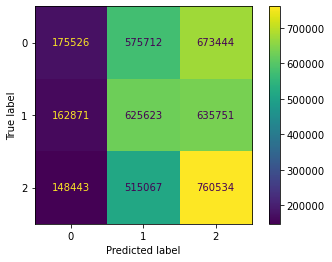

In [29]:
# Using the confusion model to how did each class perform
cm = confusion_matrix(y_test, hr_pred)
print(cm)
ConfusionMatrixDisplay(cm).plot()

In [30]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [31]:
# When reading papers, some papers recommeded using lightgbm for mutliclass classificiation. 
import lightgbm as lgb

d_train=lgb.Dataset(X_train, label=y_train)

In [32]:
# For that we used learning rate to be 0.05, and the maximum depth is 10
params={}
params['learning_rate']=0.05
params['boosting_type']='gbdt' 
params['objective']='multiclass' 
params['metric']='multi_logloss' 
params['max_depth']=10
params['num_class']=3

In [33]:
clf=lgb.train(params,d_train,100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 17091883, number of used features: 2
[LightGBM] [Info] Start training from score -1.098675
[LightGBM] [Info] Start training from score -1.098598
[LightGBM] [Info] Start training from score -1.098563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [34]:
# Fitting and predicting using the lightgbm model
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, balanced_accuracy_score
y_pred=clf.predict(X_test)
y_pred

array([[0.32493621, 0.31863693, 0.35642686],
       [0.32542339, 0.30236925, 0.37220736],
       [0.33170259, 0.35800292, 0.31029448],
       ...,
       [0.32694563, 0.31461685, 0.35843752],
       [0.34350733, 0.3568295 , 0.29966317],
       [0.33038373, 0.32536871, 0.34424756]])

In [35]:
# Predicting the next class or type
y_pred = [np.argmax(line) for line in y_pred]

y_pred

[2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 1,
 1,
 0,
 2,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 0,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 0,
 0,
 2,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 0,
 0,
 1,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 0,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 0,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 0,
 1,
 2,


In [36]:
# Using the precision score to see how did the model do in terms of precentage.
precision_score(y_pred,y_test,average=None).mean()

0.3648902522357775

In [37]:
# Using the accuracy_score to see how did the model do in terms of precentage.
accuracy_score(y_test, y_pred)

0.36485691103450035

In [38]:
cm_1 = confusion_matrix(y_test, y_pred)

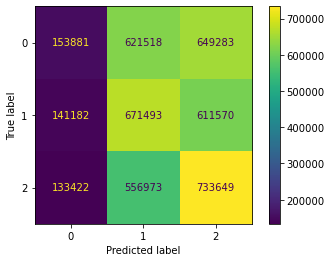

In [39]:
ConfusionMatrixDisplay(cm_1).plot()

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
# The other model that used to train and test model is using random forest. Scholars say we having multiclass classification is always best to use random forest

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

C:\Users\cs_mibra004\AppData\Local\Temp\ipykernel_20424\635094718.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [42]:
# Fitting and predicting using the Random Forest model
y_pred = classifier.predict(X_test)

In [43]:
precision_score(y_pred,y_test,average=None).mean()

0.7212292514850459

In [44]:
accuracy_score(y_test, y_pred)

0.7212218383883251

In [45]:
balanced_accuracy_score(y_test, y_pred)

0.7212292514850459

In [46]:
cm_2 = confusion_matrix(y_test, y_pred)

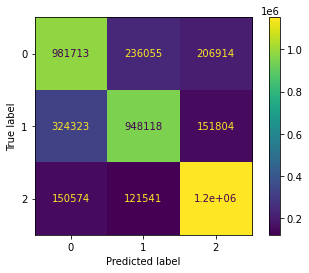

In [47]:
ConfusionMatrixDisplay(cm_2).plot()

When implementing the three models (xgboost, lightgbm, and Random Forest) on the imbalanced dataset, we concluded that using Random Forest was the best model for the dataset. It had an accuracy score of 0.72. While the other models performed poorly compared to the Random Forest. The next step is use DLRM (Deep Learning Recommendation Model) on the dataset and see which model performed better.